# Laboratorium 4
## Przecinanie się odcinków
## Anna Gut


## Konfiguracja

In [43]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [44]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Interaktywne zadawanie odcinków

<IPython.core.display.Javascript object>


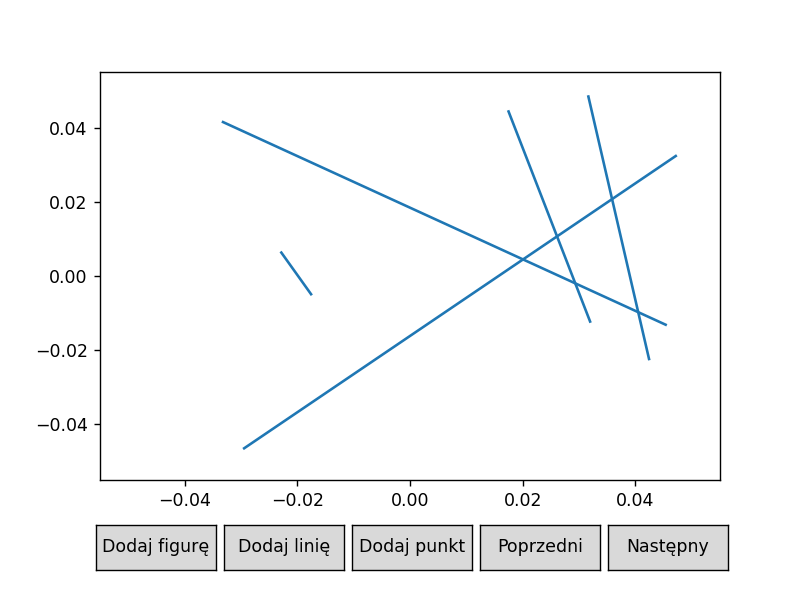

In [6]:
%matplotlib notebook
plot1=Plot()
plot1.draw()

<IPython.core.display.Javascript object>


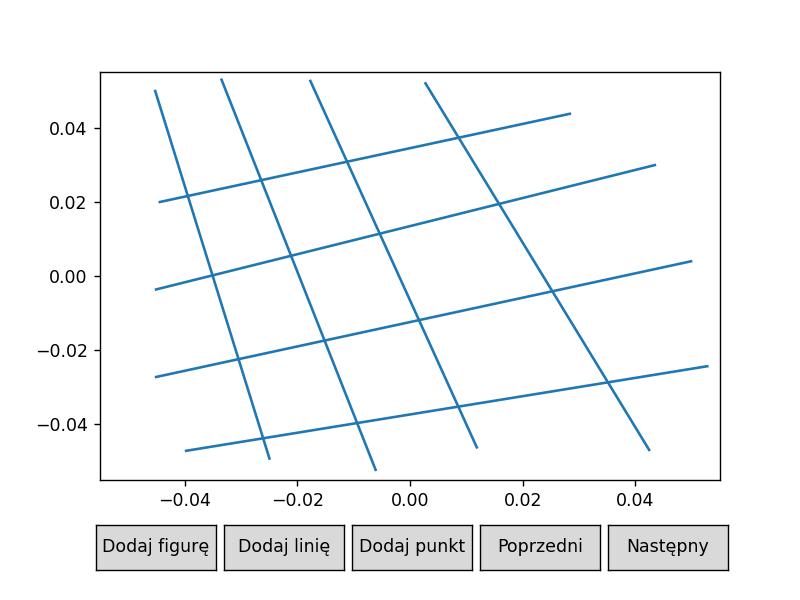

In [53]:
%matplotlib notebook
plot2=Plot()
plot2.draw()

In [12]:
from typing import List
import random
import heapq
import functools
from sortedcontainers import SortedSet

## Odczyt zadanych odcinków

In [13]:
def read_lines(plot):
    lines=plot.get_added_lines()
    li=[]
    for i in lines:
        li+=i.lines
    return list(li)

<IPython.core.display.Javascript object>


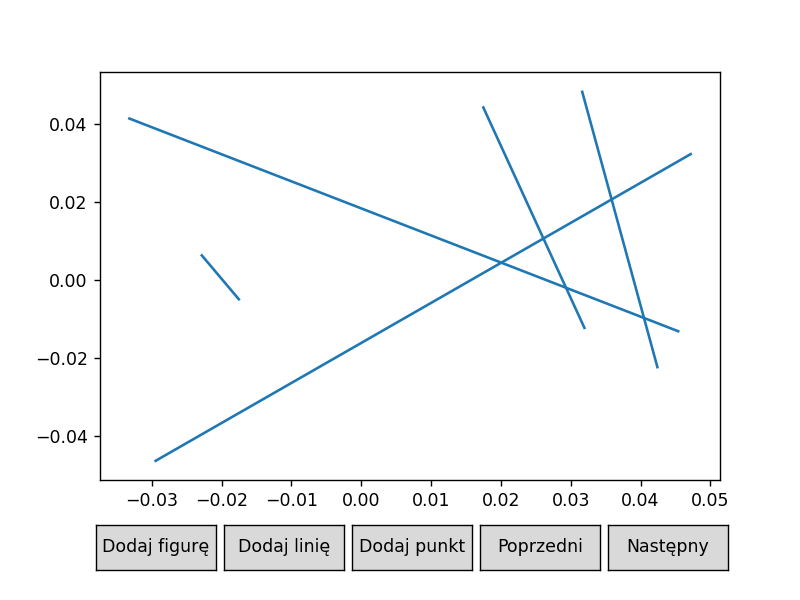

In [14]:
%matplotlib notebook
lines1=read_lines(plot1)
scenes=[Scene([PointsCollection([])],[LinesCollection(lines1)])]
plot=Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


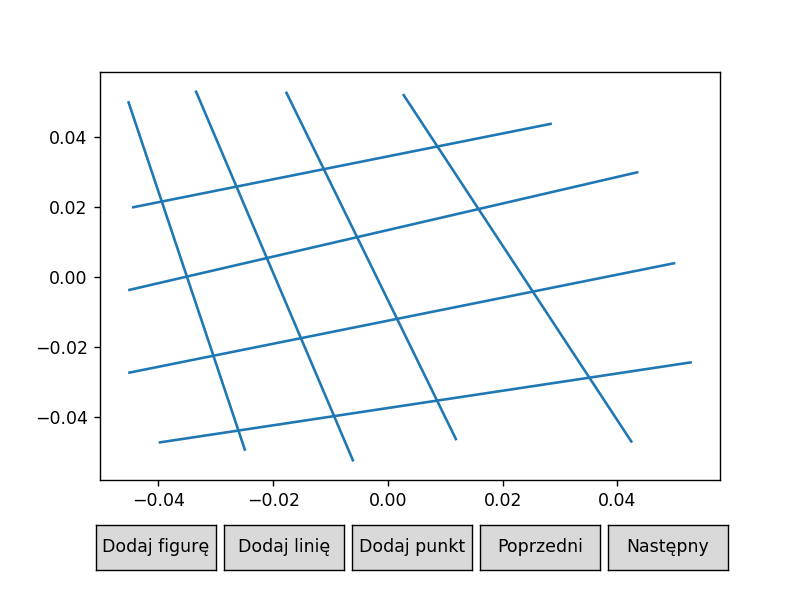

In [54]:
%matplotlib notebook
lines2=read_lines(plot2)
scenes=[Scene([PointsCollection([])],[LinesCollection(lines2)])]
plot=Plot(scenes)
plot.draw()

## Generowanie odcinków ze zbioru 2D

In [16]:
def generate_lines(lower_left,upper_right,amount):
    lines=[]
    points=set()
    for i in range (amount):
        point0=(random.uniform(lower_left[0], upper_right[0]), random.uniform(lower_left[1], upper_right[1]))
        point1=(random.uniform(lower_left[0], upper_right[0]), random.uniform(lower_left[1], upper_right[1]))
        #jesli odcinek pionowy lub punkt ten sam
        if point0[0] == point1[0]:
            i = i - 1
            continue
        #jesli odcinki o takich wspolrzednych x juz istnieja
        if point0 in points or point1 in points:
            i=i-1
            continue
        #kolejnosc punktow w odcinku na układzie współrzędnych
        if point0[0] < point1[0]:
            lines.append((point0, point1))
        else:
            lines.append((point1, point0)) 
        points.add(point0)
        points.add(point1)

    return list(lines)  

<IPython.core.display.Javascript object>


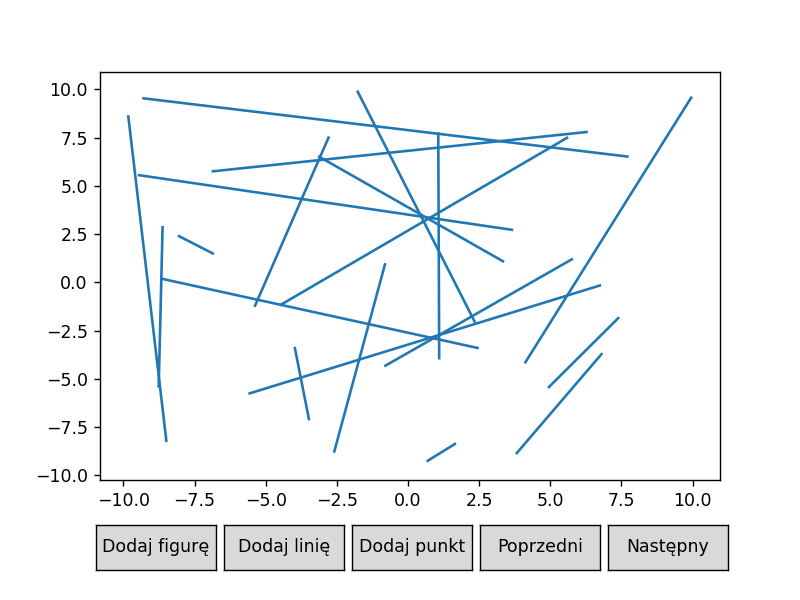

In [17]:
%matplotlib notebook
lines3=generate_lines((-10,-10),(10,10),20)
plot3=Plot([Scene([PointsCollection([])], 
              [LinesCollection(lines3)])])
plot3.draw()

<IPython.core.display.Javascript object>


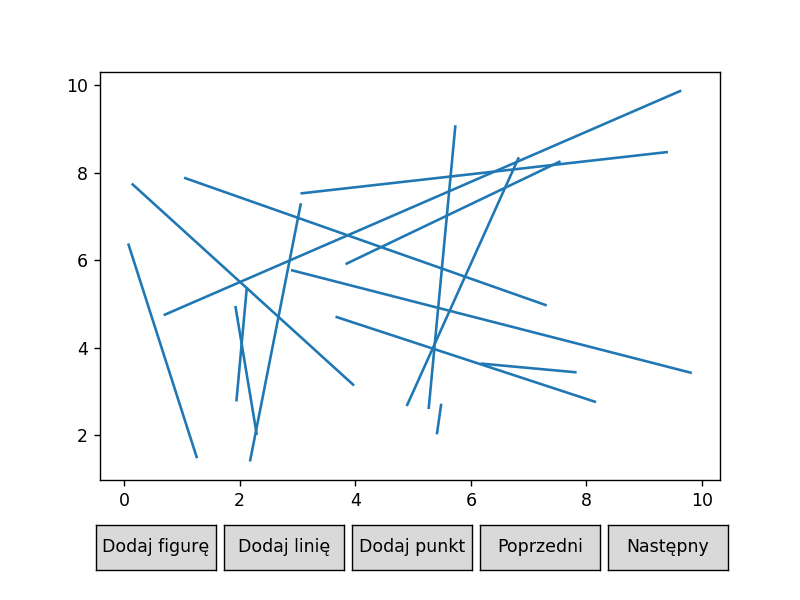

In [18]:
%matplotlib notebook
lines4=generate_lines((0,0),(10,10),15)
plot4=Plot([Scene([PointsCollection([])], 
              [LinesCollection(lines4)])])
plot4.draw()

## Wykrywanie jednego punktu przecięcia

In [19]:
def det3x3(a,b,c):
     return a[0] * b[1] + a[1]  * c[0] +  b[0] * c[1] - b[1] * c[0] - a[1] * b[0] -a[0] * c[1]

In [20]:
def orient(a, b, c, e=10**(-10)):
    det = det3x3(a, b, c)
    #po prawej
    if det > e:
        return 1
    #po lewej
    if det < -e:
        return -1
    #wspolliniowe
    else:
        return det

In [35]:
class Sweeper:
    def __init__(self, lines_set,lower_left,upper_right):
        
        self.lines_set=lines_set
        self.scenes = []
        #struktura stanu
        self.lines = SortedSet(key=lambda line: line[0][1])
        #struktura zdarzeń
        self.events = []
        self.ll=lower_left
        self.ur=upper_right
        #dodajemy do struktury zdarzeń wszystkie początki i końce odcinków wraz z odcinkami do których należą
        for line in lines_set:
            #wspolrzedne x koncow odcinkow
            self.events.append((line[0][0], line))
            self.events.append((line[1][0], line))
        #kolejka priorytetowa typu min
        heapq.heapify(self.events)
        
    def is_intersection(self, line1, line2):
        #jezeli caly odcinek lezy nad lub pod drugim to nie przecinają się
        return orient(line1[0], line1[1],line2[0] ) != orient(line1[0],line1[1],line2[1] ) and orient(line2[0],line2[1],line1[0])!=orient(line2[0], line2[1],line1[1])

    def sweep(self):
        b=True
        while self.events:
            event=heapq.heappop(self.events)
            if self.happened(event):               
                b=False
                break
        if b:
            print('Żadna para odcinków nie przecina się')
    
    def insert(self, line):
        self.lines.add(line)
        idx = self.lines.index(line)
        if idx-1>=0:
            return self.is_intersection(self.lines[idx-1], line)
        if idx+1<len(self.lines):
            return self.is_intersection(self.lines[idx+1], line)

    def remove(self, line):
        idx = self.lines.index(line)
        if idx-1>=0 and idx+1<len(self.lines):
            return self.is_intersection(self.lines[idx-1], self.lines[idx+1])
        self.lines.remove(line)
    
    def happened(self, event):
        #jesli poczatek odcinka
        if event[0] == event[1][0][0]:
            self.scenes.append(Scene(
                [PointsCollection([event[1][0]],color='red')],
                [LinesCollection(list(self.lines_set)), LinesCollection([ ((event[0], self.ll[1]), (event[0], self.ur[1])) ], color='red')]))
            return self.insert(event[1])
        #jesli koniec odcinka
        else:
            self.scenes.append(Scene(
                [PointsCollection([event[1][1]],color='red')],
                [LinesCollection(self.lines_set), LinesCollection([((event[0], self.ll[1]), (event[0], self.ur[1])) ], color='red')]))
            return self.remove(event[1])

Co najmniej jedna para odcinków przecina się.


<IPython.core.display.Javascript object>


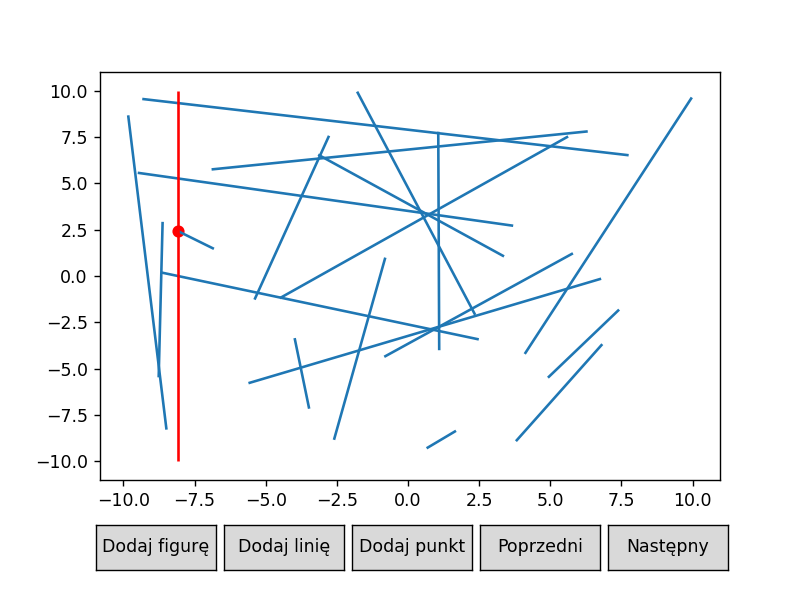

In [34]:
%matplotlib notebook
sweeper = Sweeper(lines3,(-10,-10),(10,10))
sweeper.sweep()
plot= Plot(sweeper.scenes)
plot.draw()

## Wyznaczanie wszystkich punktów przecięć

In [36]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def lines(self, line1, line2):
        self.line1=line1
        self.line2=line2
        
    def __eq__(self, point):
        return isinstance(point, Point) and self.x == point.x and self.y == point.y

    def __hash__(self):
        return self.x.__hash__()*self.y.__hash__()

    def __gt__(self, point):
        return isinstance(point, Point) and self.x > point.x

    def __ge__(self, point):
        return isinstance(point, Point) and self.x >= point.x

    def __le__(self,point):
        return isinstance(point, Point) and self.x <= point.x

    def __lt__(self, point):
        return isinstance(point, Point) and self.x < point.x
    
    def to_tuple(self):
        return self.x, self.y
    
    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'

In [37]:
class Line:

    def __init__(self, point0, point1):
        if point0.x < point1.x:
            self.point0 = point0
            self.point1 = point1
        else:
            self.point0 = point1
            self.point1 = point0
            
    def slope(self):
        return (self.point1.y - self.point0.y) / (self.point1.x - self.point0.x)

    def get_b(self):
        return self.point1.y - self.slope() * self.point1.x

    def get_y(self, x):
        return self.slope() * x + self.get_b()

    def to_tuple(self):
        return self.point0.to_tuple(), self.point1.to_tuple()

    def __str__(self):
        return '(' + str(self.point0) + ', ' + str(self.point1) + ')'

In [38]:
def line_intersection(line1, line2):
    if (orient(line1.point0.to_tuple(), line1.point1.to_tuple(),line2.point0.to_tuple()) != orient(line1.point0.to_tuple(),line1.point1.to_tuple(),line2.point1.to_tuple()) and orient(line2.point0.to_tuple(),line2.point1.to_tuple(),line1.point0.to_tuple())!=orient(line2.point0.to_tuple(), line2.point1.to_tuple(),line1.point1.to_tuple())):

        a1=(line1.point1.y-line1.point0.y)/(line1.point1.x-line1.point0.x)
        a2=(line2.point1.y-line2.point0.y)/(line2.point1.x-line2.point0.x)
        b1=line1.point0.y-line1.point0.x*a1
        b2=line2.point0.y-line2.point0.x*a2
        x=round((b2-b1)/(a1-a2),4)
        y=round(a1*(b2-b1)/(a1-a2)+b1,4)
        point=Point(x,y)
        point.lines(line1, line2)
        return point
    
    return None

In [39]:
def listtoclass(lines):
    lines1=[]
    for line in lines:
        point0=Point(line[0][0],line[0][1])
        point1=Point(line[1][0],line[1][1])
        lines1.append(Line(point0,point1))
    return lines1

In [40]:
class Sweeper1:
    
    def __init__(self):
        
        self.lines = SortedSet()
        #zdarzenia
        self.events = SortedSet(key=lambda point:-point.x)
        self.scenes = []
        #stan miotły
        self.lines_set = {}
        #lista przecięć
        self.intersections = set()

    def sweep(self,lines):
        
        for line in lines:
            self.lines_set[line.point0] = line
            self.lines_set[line.point1] = line
            self.events.add(line.point0)
            self.events.add(line.point1)
        lowest = functools.reduce(lambda curr, point: point if point.y<curr.y else curr, self.lines_set.keys()).y
        highest = functools.reduce(lambda curr, point: point if point.y>curr.y else curr, self.lines_set.keys()).y
        
        #aktywne odcinki porzadkowane wedlug wspolrzednej y w punkcie self.events[0].x
        tmp = SortedSet(key=lambda line: line.get_y(self.events[0].x))
        tmp.update(self.lines)
        self.lines = tmp
        
        while len(self.events)>0:
            event = self.events.pop()
    
            self.scenes.append(Scene([PointsCollection([event.to_tuple()], color='red'),
                                 PointsCollection(list(map(lambda point: point.to_tuple(), self.intersections)),color='red')],
                                [LinesCollection(list(map(lambda line: line.to_tuple(), lines))),
                                 LinesCollection([ ((event.x, lowest), (event.x, highest)) ], color='red')]))
            
            self.happened(event)
        return self.intersections

    def find_intersection(self, line1, line2):
        
        return line_intersection(line1, line2)

    def insert(self, line):
        self.lines.add(line)
        idx = self.lines.index(line)

        if idx - 1 >= 0 and idx + 1 < len(self.lines):
            intersection = self.find_intersection(self.lines[idx - 1], self.lines[idx+ 1])
            if intersection is not None and intersection in self.events:
                self.events.remove(intersection)
        if idx - 1 >= 0:
            intersection = self.find_intersection(self.lines[idx - 1], line)
            if intersection is not None and intersection not in self.intersections and intersection not in self.events:
                self.events.add(intersection)
        if idx + 1 < len(self.lines):
            intersection = self.find_intersection(line, self.lines[idx + 1])
            if intersection is not None and intersection not in self.intersections and intersection not in self.events:
                self.events.add(intersection)

    def remove(self, line):
        idx = self.lines.index(line)
        if idx - 1 >= 0 and idx + 1 < len(self.lines):
            intersection = self.find_intersection(self.lines[idx - 1], self.lines[idx + 1])
            if intersection is not None and intersection not in self.intersections:
                self.events.add(intersection)
        self.lines.remove(line)

    def add_intersection(self, intersection):
        
        self.intersections.add(intersection)
        line1 = intersection.line1
        line2 = intersection.line2

        self.remove(line1)
        self.remove(line2)
        
        tmp = SortedSet(key=lambda line: line.get_y(intersection.x + 0.01))
        tmp.update(self.lines)
        self.lines = tmp

        self.insert(line1)
        self.insert(line2)

    def happened(self, event):
        if event in self.lines_set:
            line = self.lines_set[event]
            if event == line.point0:
                tmp = SortedSet(key=lambda line: line.get_y(event.x))
                tmp.update(self.lines)
                self.lines = tmp
                self.insert(line)
            else:
                tmp = SortedSet(key=lambda line: line.get_y(event.x))
                tmp.update(self.lines)
                self.lines = tmp
                self.remove(line)
        else:
            self.add_intersection(event)

Liczba punktów przecięć: 5
Punkt: (0.0405, -0.0097)
Linie: ((-0.03338533401489259, 0.04165020119910148), (0.04556627888833323, -0.013282396840114216)) ((0.031594504694784836, 0.04872740708145443), (0.0424614401786558, -0.022718671349918132))
Punkt: (0.0261, 0.0107)
Linie: ((0.017400956307688065, 0.04468328943439562), (0.03203805308188161, -0.012608377232271067)) ((-0.029615172724570003, -0.04664636742834952), (0.04734047243672032, 0.032550936493219135))
Punkt: (0.0359, 0.0207)
Linie: ((-0.029615172724570003, -0.04664636742834952), (0.04734047243672032, 0.032550936493219135)) ((0.031594504694784836, 0.04872740708145443), (0.0424614401786558, -0.022718671349918132))
Punkt: (0.0293, -0.002)
Linie: ((-0.03338533401489259, 0.04165020119910148), (0.04556627888833323, -0.013282396840114216)) ((0.017400956307688065, 0.04468328943439562), (0.03203805308188161, -0.012608377232271067))
Punkt: (0.0201, 0.0045)
Linie: ((-0.029615172724570003, -0.04664636742834952), (0.04734047243672032, 0.032550936

<IPython.core.display.Javascript object>


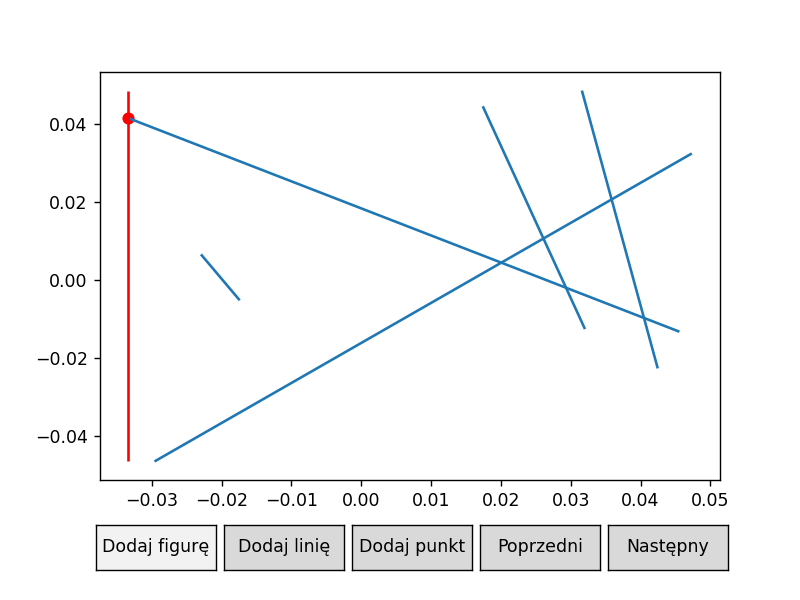

In [41]:
%matplotlib notebook
sweeper = Sweeper1()
result = sweeper.sweep(listtoclass(lines1))
print('Liczba punktów przecięć: ' + str(len(result)))
for p in result:
    print('Punkt: ' + str(p))
    print('Linie: ' + str(p.line1) + ' ' + str(p.line2))
plot = Plot(sweeper.scenes)
plot.draw()

Liczba punktów przecięć: 16
Punkt: (-0.0152, -0.0174)
Linie: ((-0.04527243214268839, -0.027302006740196075), (0.050090471083118066, 0.004039905024509821)) ((-0.03351839988462387, 0.05324333639705886), (-0.006018399884623868, -0.05257774203431373))
Punkt: (-0.0054, 0.0114)
Linie: ((-0.017772432142688387, 0.05290632659313729), (0.011945309792795483, -0.046511565563725495)) ((-0.04527243214268839, -0.0037113204656862575), (0.043659019470214847, 0.02998965992647061))
Punkt: (0.0253, -0.0041)
Linie: ((-0.04527243214268839, -0.027302006740196075), (0.050090471083118066, 0.004039905024509821)) ((0.002630793663763231, 0.05223230698529416), (0.042550148502472906, -0.04718558517156863))
Punkt: (-0.0094, -0.0396)
Linie: ((-0.0399498514975271, -0.04718558517156863), (0.052973535599247085, -0.024268918504901954)) ((-0.03351839988462387, 0.05324333639705886), (-0.006018399884623868, -0.05257774203431373))
Punkt: (-0.0304, -0.0224)
Linie: ((-0.04527243214268839, 0.050210248161764726), (-0.02486920633

<IPython.core.display.Javascript object>


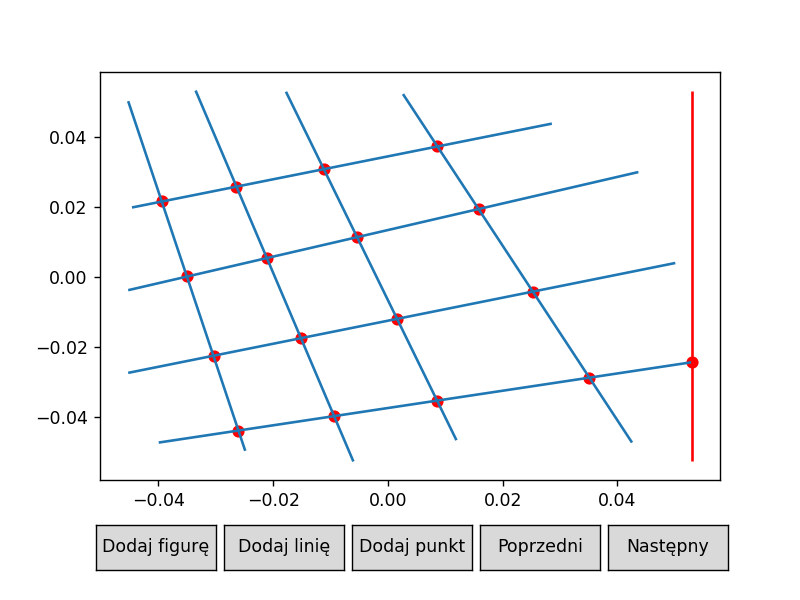

In [55]:
%matplotlib notebook
sweeper = Sweeper1()
result = sweeper.sweep(listtoclass(lines2))
print('Liczba punktów przecięć: ' + str(len(result)))
for p in result:
    print('Punkt: ' + str(p))
    print('Linie: ' + str(p.line1) + ' ' + str(p.line2))
plot = Plot(sweeper.scenes)
plot.draw()

Liczba punktów przecięć: 37
Punkt: (-7.357, -5.9129)
Linie: ((-9.740855768091485, -7.998576716292138), (5.094058484089274, 4.980903712634127)) ((-7.801358510745797, -5.837320811856506), (-1.9641141897991012, -6.830292982411121))
Punkt: (-3.4362, -0.833)
Linie: ((-7.493315805608138, -1.621021809914966), (4.242499585209124, 0.6584135449592665)) ((-3.8072019198435676, -0.28518184285999126), (0.6272774614758596, -6.833308544197722))
Punkt: (1.1099, 1.4951)
Linie: ((-9.740855768091485, -7.998576716292138), (5.094058484089274, 4.980903712634127)) ((-0.5949568693084615, 3.8329070456606917), (5.524978372966709, -4.559066429446805))
Punkt: (-0.8828, 7.9914)
Linie: ((-7.038026353202326, -9.99756598521904), (-0.46877932966790326, 9.201372969880577)) ((-2.7610232744737306, 7.740636884035492), (9.96414216588607, 9.439898061369789))
Punkt: (-1.7559, -1.0123)
Linie: ((-9.740855768091485, -7.998576716292138), (5.094058484089274, 4.980903712634127)) ((-4.431679542706551, -0.9541885429082502), (2.627790

<IPython.core.display.Javascript object>


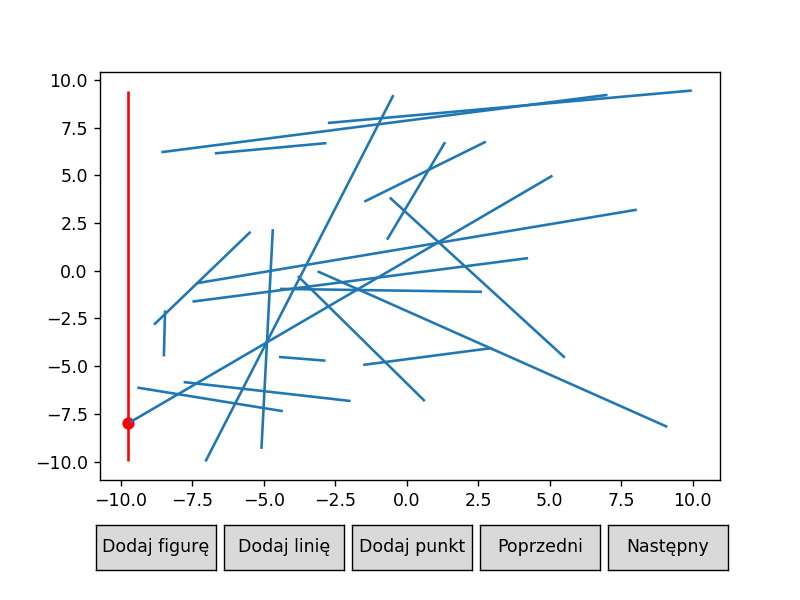

In [120]:
%matplotlib notebook
sweeper = Sweeper1()
result = sweeper.sweep(listtoclass(lines3))
print('Liczba punktów przecięć: ' + str(len(result)))
for p in result:
    print('Punkt: ' + str(p))
    print('Linie: ' + str(p.line1) + ' ' + str(p.line2))
plot = Plot(sweeper.scenes)
plot.draw()

Liczba punktów przecięć: 16
Punkt: (9.4044, 6.6692)
Linie: ((9.193029706575647, 2.9109000005075556), (9.565299127300978, 9.529476130596542)) ((8.2722295933415, 8.621265906067398), (9.855065657321783, 5.892268526319128))
Punkt: (5.9349, 5.0219)
Linie: ((4.537644382480294, 3.8670604863034344), (7.4363936962982455, 6.262898747241504)) ((2.780473628268875, 5.228318647173706), (9.822880432875792, 4.76745793054125))
Punkt: (5.797, 4.9079)
Linie: ((5.611839288414537, 4.446678187311353), (7.660025387303894, 9.54888368543529)) ((4.537644382480294, 3.8670604863034344), (7.4363936962982455, 6.262898747241504))
Punkt: (5.8451, 5.0278)
Linie: ((5.611839288414537, 4.446678187311353), (7.660025387303894, 9.54888368543529)) ((2.780473628268875, 5.228318647173706), (9.822880432875792, 4.76745793054125))
Punkt: (8.4233, 1.3873)
Linie: ((8.321020521720774, 0.8003626643784223), (9.396127659998587, 6.969028766430272)) ((2.9006570153942333, 4.22079037253964), (9.657482302325816, 0.7540492073641536))
Punkt: 

<IPython.core.display.Javascript object>


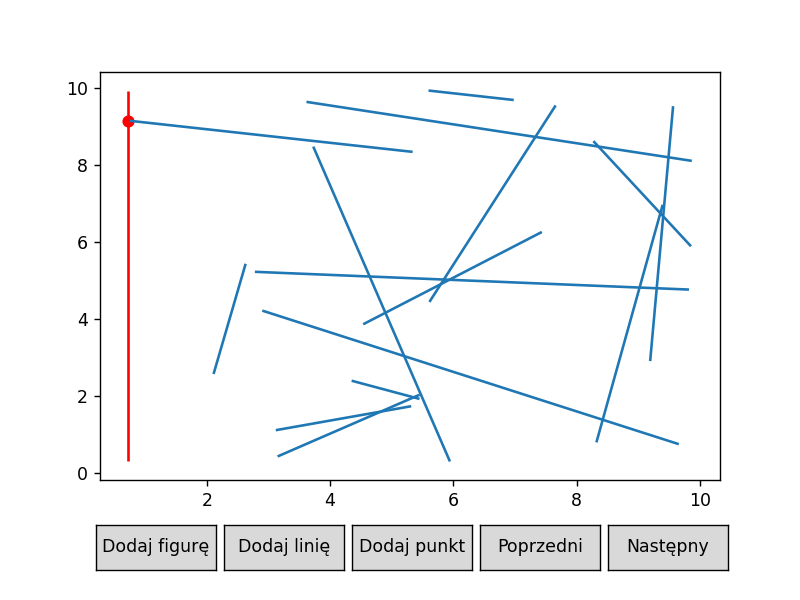

In [121]:
%matplotlib notebook
sweeper = Sweeper1()
result = sweeper.sweep(listtoclass(lines4))
print('Liczba punktów przecięć: ' + str(len(result)))
for p in result:
    print('Punkt: ' + str(p))
    print('Linie: ' + str(p.line1) + ' ' + str(p.line2))
plot = Plot(sweeper.scenes)
plot.draw()